In [ ]:
# set visible devices
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
import os
os.chdir("/workspace/")
import sys
sys.path.append("/workspace/reni_neus")


import torch
import yaml
from pathlib import Path
import random
import matplotlib.pyplot as plt
import numpy as np
import tqdm
import plotly.graph_objects as go
from torch.utils.data import Dataset

from nerfstudio.configs import base_config as cfg
from nerfstudio.configs.method_configs import method_configs
from nerfstudio.data.dataparsers.nerfosr_dataparser import NeRFOSR, NeRFOSRDataParserConfig
from nerfstudio.pipelines.base_pipeline import VanillaDataManager
from nerfstudio.field_components.field_heads import FieldHeadNames
from nerfstudio.cameras.rays import RayBundle
from nerfstudio.utils.colormaps import apply_depth_colormap
from nerfstudio.field_components.encodings import SHEncoding, NeRFEncoding
import tinycudann as tcnn

from reni_neus.reni_neus_model import RENINeuSFactoModelConfig, RENINeuSFactoModel
from reni_neus.utils.utils import get_directions, get_sineweight, look_at_target, random_points_on_unit_sphere
from reni_neus.illumination_fields.reni_field import RENIField
from reni_neus.data.reni_neus_datamanager import RENINeuSDataManagerConfig, RENINeuSDataManager
from reni_neus.reni_neus_config import RENINeuS as RENINeuSMethodSpecification, DirectionalDistanceField  

def sRGB(imgs):
    # Add batch dimension if necessary
    if imgs.ndim == 3:
        imgs = imgs.unsqueeze(0)
    
    # Calculate the 98th percentile for each image
    q = torch.quantile(imgs.view(imgs.size(0), -1), 0.98, dim=1)
    
    # Normalize images by their 98th percentile
    imgs = imgs / q.view(-1, 1, 1, 1)
    
    # Clamp the pixel values between 0.0 and 1.0
    imgs = torch.clamp(imgs, 0.0, 1.0)
    
    # Convert linear RGB to sRGB using the sRGB conversion formula
    mask = imgs <= 0.0031308
    imgs_sRGB = imgs = torch.where(
        imgs <= 0.0031308,
        12.92 * imgs,
        1.055 * torch.pow(torch.abs(imgs), 1 / 2.4) - 0.055,
    )
    return imgs_sRGB

def rotation_matrix(axis, angle):
    """
    Return 3D rotation matrix for rotating around the given axis by the given angle.
    """
    axis = np.asarray(axis)
    axis = axis / np.sqrt(np.dot(axis, axis))
    a = np.cos(angle / 2.0)
    b, c, d = -axis * np.sin(angle / 2.0)
    aa, bb, cc, dd = a * a, b * b, c * c, d * d
    bc, ad, ac, ab, bd, cd = b * c, a * d, a * c, a * b, b * d, c * d
    return np.array([[aa + bb - cc - dd, 2 * (bc + ad), 2 * (bd - ac)],
                     [2 * (bc - ad), aa + cc - bb - dd, 2 * (cd + ab)],
                     [2 * (bd + ac), 2 * (cd - ab), aa + dd - bb - cc]])

# setup config
test_mode = 'val'
world_size = 1
local_rank = 0
device = 'cuda:0'

ckpt_path = '/workspace/outputs/unnamed/reni-neus/2023-05-23_191641/'
step = 70000

ckpt = torch.load(ckpt_path + '/nerfstudio_models' + f'/step-{step:09d}.ckpt', map_location=device)
model_dict = {}
for key in ckpt['pipeline'].keys():
    if key.startswith('_model.'):
        model_dict[key[7:]] = ckpt['pipeline'][key]

# load yaml checkpoint config
config_path = Path(ckpt_path) / 'config.yml'
config = yaml.load(config_path.open(), Loader=yaml.Loader)
pipeline_config = config.pipeline

datamanager: RENINeuSDataManager = pipeline_config.datamanager.setup(
    device=device, test_mode=test_mode, world_size=world_size, local_rank=local_rank, 
)
datamanager.to(device)
# includes num_eval_data as needed for reni latent code fitting.
model = pipeline_config.model.setup(
    scene_box=datamanager.train_dataset.scene_box,
    num_train_data=len(datamanager.train_dataset),
    num_val_data=datamanager.num_val,
    num_test_data=datamanager.num_test,
    test_mode=test_mode,
)
model.to(device)
model.load_state_dict(model_dict)
model.eval()

print('Model loaded')

Setting up training dataset...

Caching all 160 images.

Output()

Setting up evaluation dataset...

Caching all 5 images.

Output()

Model loaded


In [7]:
model_dict['field.aabb']

tensor([[-1., -1., -1.],
        [ 1.,  1.,  1.]], device='cuda:0')

In [9]:
# Assuming your 3D space ranges from -1 to 1 in each dimension with a resolution of 0.1
grid_range = torch.arange(-1, 1, 0.1)
x, y, z = torch.meshgrid(grid_range, grid_range, grid_range)

# Stack the coordinates together into [3, N] tensor, where N is the total number of grid points
grid_points = torch.stack([x.reshape(-1), y.reshape(-1), z.reshape(-1)], dim=0)

# Evaluate the density function at all grid points
densities = model.density_fns[0](grid_points)


/home/user/.local/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/home/user/.local/lib/python3.10/site-packages/tinycudann/modules.py:169: UserWarning: input must be a CUDA tensor, but isn't. This indicates suboptimal performance.
  warnings.warn("input must be a CUDA tensor, but isn't. This indicates suboptimal performance.")


RuntimeError: shape '[3, -1]' is invalid for input of size 8000

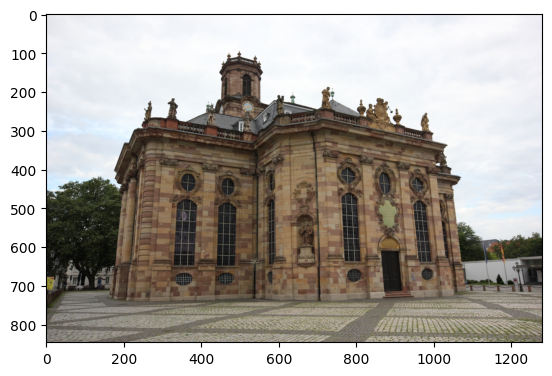

In [3]:
ray_bundle, batch = datamanager.fixed_indices_eval_dataloader.get_data_from_image_idx(0)
plt.imshow(batch['image'].cpu().numpy())

In [ ]:
# get the c2w matrix of the camera
idx = 0
old_c2w = datamanager.eval_dataloader.cameras[idx].camera_to_worlds.detach().clone() # [3, 4]
new_pos = random_points_on_unit_sphere(1)

new_c2w = look_at_target(new_pos.cpu(), torch.tensor([0.0, 0.0, 0.0]))[:3, :4] # [3, 4] # C2W matrix looking at the center of the scene

datamanager.eval_dataloader.cameras.camera_to_worlds[idx].copy_(new_c2w)

camera_ray_bundle, batch = datamanager.eval_dataloader.get_data_from_image_idx(idx)

model.config.eval_num_rays_per_chunk = 2048

outputs = model.get_outputs_for_camera_ray_bundle(camera_ray_bundle, show_progress=True)

# set the c2w matrix back to the original one
datamanager.eval_dataloader.cameras.camera_to_worlds[idx].copy_(old_c2w)

In [3]:
# ray_bundle.nears = torch.zeros_like(ray_bundle.metadata['directions_norm']) + 0.05
# ray_bundle.fars = torch.zeros_like(ray_bundle.metadata['directions_norm']) + 1.0
outputs = model.get_outputs_for_camera_ray_bundle(ray_bundle, show_progress=True)

Output()

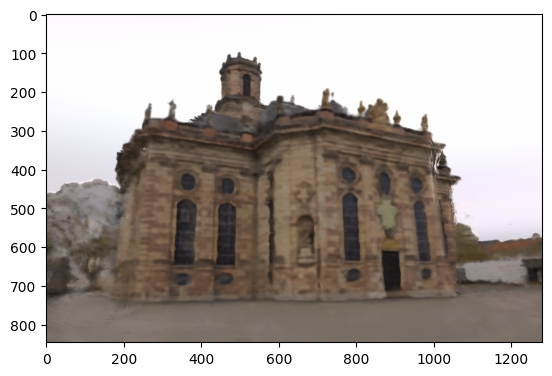

In [5]:
plt.imshow(outputs['rgb'].cpu().numpy())

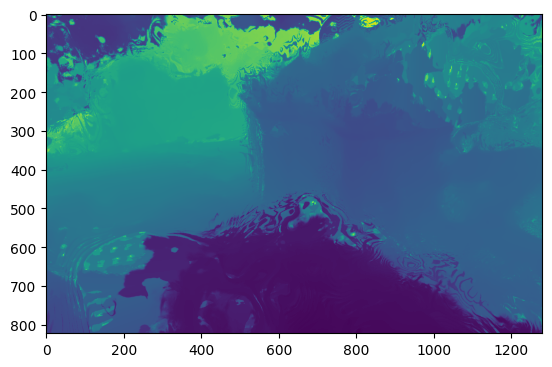

In [1]:
import torch

path = '/workspace/outputs/ddf/cache/lk2_data.pt'

data = torch.load(path)[0]

img = data['termination_dist']
H = data['H']
W = data['W']

img = img.reshape(H, W, 1)

import matplotlib.pyplot as plt
plt.imshow(img.cpu().numpy())

In [2]:
img.min(), img.max()

(tensor(0.2336, device='cuda:0'), tensor(2.2447, device='cuda:0'))

In [9]:
data['ray_bundle']

RayBundle(origins=tensor([[ 0.7569, -0.2655,  0.5972],
        [ 0.7569, -0.2655,  0.5972],
        [ 0.7569, -0.2655,  0.5972],
        ...,
        [ 0.7569, -0.2655,  0.5972],
        [ 0.7569, -0.2655,  0.5972],
        [ 0.7569, -0.2655,  0.5972]], device='cuda:0'), directions=tensor([[-0.9554, -0.2019, -0.2156],
        [-0.9555, -0.2013, -0.2157],
        [-0.9556, -0.2006, -0.2158],
        ...,
        [-0.2538,  0.6248, -0.7384],
        [-0.2534,  0.6253, -0.7381],
        [-0.2531,  0.6258, -0.7378]], device='cuda:0'), pixel_area=tensor([[5.1192e-07, 5.1250e-07, 5.1308e-07,  ..., 5.1247e-07, 5.1184e-07,
         5.1132e-07],
        [5.1192e-07, 5.1250e-07, 5.1308e-07,  ..., 5.1247e-07, 5.1184e-07,
         5.1132e-07],
        [5.1192e-07, 5.1250e-07, 5.1308e-07,  ..., 5.1247e-07, 5.1184e-07,
         5.1132e-07],
        ...,
        [5.1192e-07, 5.1250e-07, 5.1308e-07,  ..., 5.1247e-07, 5.1184e-07,
         5.1132e-07],
        [5.1192e-07, 5.1250e-07, 5.1308e-07,  ..., 